## Imports

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import seaborn as sea
from tqdm.notebook import tqdm
plt.style.use('seaborn')
# import urllib.request
import requests
from io import BytesIO
import cv2
import torchvision
import torchvision.transforms as transforms
import time
os.environ['TORCH_MODEL_ZOO'] = '/scratch/fk/'

# kaggle datasets download -d dansbecker/cityscapes-image-pairs

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

def get_num_parameters(model):
    counter = 0
    for param in model.parameters():
        counter += param.numel()
    print(f"Number of parameters: {counter:,}")
    
    
def get_image(url, img_size=(224, 224)):
    response = requests.get(url)
    image_data = response.content

    # Open the image using PIL (Python Imaging Library)
    img = np.array(Image.open(BytesIO(image_data)))
    if img_size is not None:
        img = cv2.resize(img, img_size)
    return img

imagenet = {}

with open('./imagenet_classes.txt', "r") as f:
    line = f.read()
    
for l in line.split('\n'):
    l = l.split(':')
    imagenet[int(l[0])] = l[1][1:-1]
    


cuda:0


## Q1: Segmentation 

### 1. Preparation

In [3]:
data_dir = '/scratch/fk/cityscapes_data'

train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


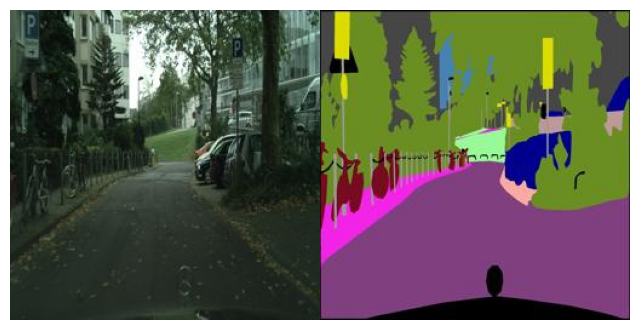

In [4]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = plt.imread(sample_image_fp)
plt.imshow(sample_image)
plt.axis('off')
plt.show()

In [5]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

(-0.5, 255.5, 255.5, -0.5)

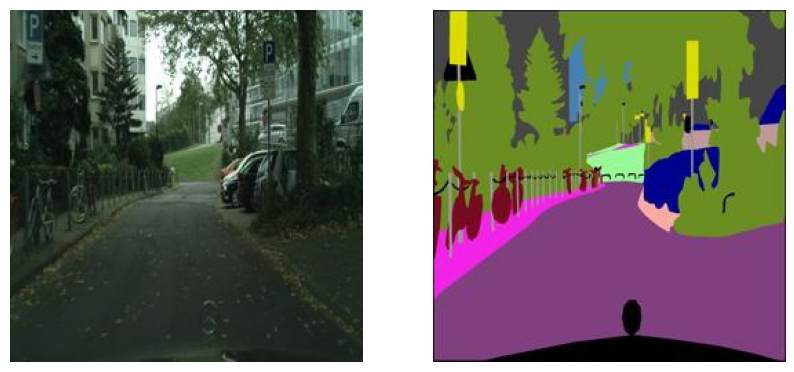

In [6]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[0].axis('off')
axes[1].imshow(label)
axes[1].axis('off')

In [7]:
class KMeansTorch:
    def __init__(self, num_clusters, max_iters=200, device='cuda'):
        self.num_clusters = num_clusters
        self.max_iters = max_iters
        self.device = device
        self.centroids = None

    def forward(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).to(self.device)
        elif isinstance(X, list):
            X = torch.stack(X).to(self.device)
            
        N, D = X.shape
        self.centroids = X[torch.randperm(N)[:self.num_clusters]].to(self.device)
        
        for _ in tqdm(range(self.max_iters)):
            distances = torch.cdist(X, self.centroids)
            assignments = torch.argmin(distances, dim=1)
            for i in range(self.num_clusters):
                cluster_points = X[assignments == i]
                if len(cluster_points) > 0:
                    self.centroids[i] = cluster_points.mean(dim=0)

    def fit(self, X):
        self.forward(X)

    def predict(self, X, return_cpu=True): 
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))
        X = X.to(device)
        distances = torch.cdist(X, self.centroids)
        assignments = torch.argmin(distances, dim=1)
        return assignments.cpu() if return_cpu else assignments

In [8]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3).astype(np.float32)
print(color_array.shape)

(1000, 3)


In [9]:
kmeans = KMeansTorch(num_clusters=10)
kmeans.fit(color_array)
colors = kmeans.centroids
colors_np = colors.cpu().numpy()


  0%|          | 0/200 [00:00<?, ?it/s]

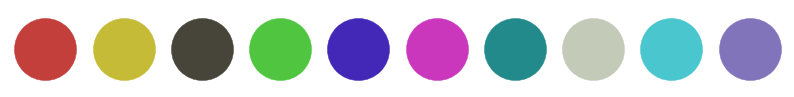

In [10]:
plt.figure(figsize=(10, 1))
for i, color in enumerate(colors_np):
    plt.scatter(i, 0, color=[c / 255 for c in color], s=2000)
    
plt.axis('off')
plt.show()

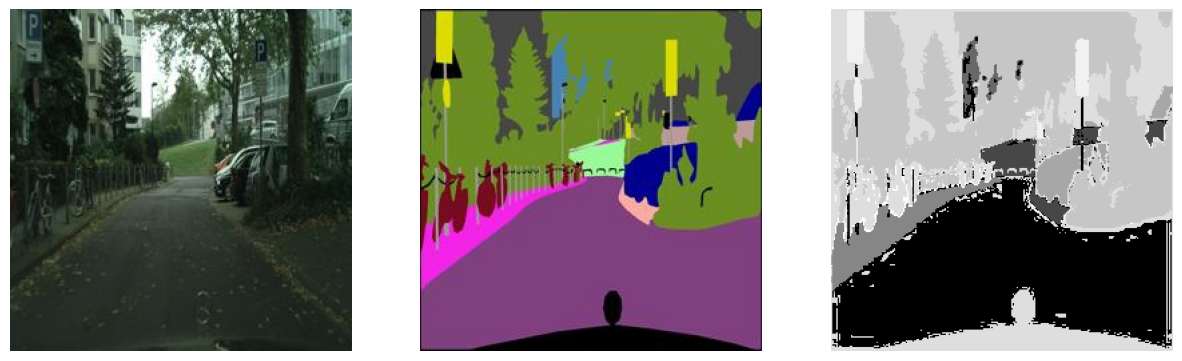

In [11]:
cityscape, label = split_image(sample_image)
label_class = kmeans.predict(label.reshape(-1,3)).numpy().reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(cityscape)
axes[0].axis('off')
axes[1].imshow(label)
axes[1].axis('off')
axes[2].imshow(label_class)
axes[2].axis('off')

plt.show()

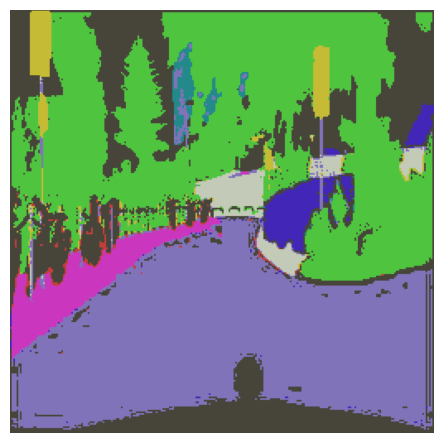

In [12]:

def convert_label_to_image(label_img, device=device):
    img = torch.zeros((256*256, 3), device=device)
    if isinstance(label_img, np.ndarray):
        label_img = torch.from_numpy(label_img).to(device)
        
    label_img = label_img.view(-1)

    for label in range(10):
        indices = torch.where(label_img == label)[0]
        img[indices] = colors[label].repeat(len(indices), 1)
        
    img = img.view((256, 256, 3))/255.0
    return img.cpu()

img = convert_label_to_image(label_class).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()



In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, centroids, transforms=None):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.centroids = centroids
        self.transforms = transforms
        
    def kmeans_predict(self, X):
        distances = torch.cdist(X, self.centroids)
        assignments = torch.argmin(distances, dim=1)
        return assignments

    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = plt.imread(image_fp).astype(np.float32)
        cityscape, label = self.split_image(image)
        
        label = torch.from_numpy(label.reshape(-1, 3))
        label_class = self.kmeans_predict(label).view(256, 256)
        
        if self.transforms is not None:
            cityscape = self.transforms(cityscape)/255.0
        
        return cityscape, label_class

    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    

In [14]:

batch_size = 8

train_dataset = CityscapeDataset(train_dir, centroids=colors.cpu(), transforms=transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers=5)

val_dataset = CityscapeDataset(val_dir, centroids=colors.cpu(), transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 256, 256]))

In [15]:
a = torch.permute(a, (0, 2, 3, 1)).numpy()
a.shape

(8, 256, 256, 3)

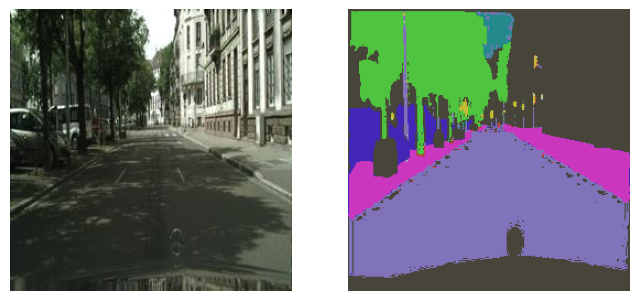

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(a[5])
plt.axis('off')

label2img = convert_label_to_image(b[5])
plt.subplot(1,2,2)
plt.imshow(label2img)
plt.axis('off')

plt.show()

### 2. Importance of skip connections

In [6]:
class UNet(nn.Module):
    
    def __init__(self, num_classes, skips=True):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.skips = skips
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.out_channels = 1024
        
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024 if self.skips else 512, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512 if self.skips else 256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256 if self.skips else 128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128 if self.skips else 64, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        
        # encoder
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        
        # bottleneck
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        
        # decoder
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]

        expansive_12_out = self.expansive_12(
            torch.cat((expansive_11_out, contracting_41_out), dim=1) if self.skips else expansive_11_out) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        
        expansive_22_out = self.expansive_22(
            torch.cat((expansive_21_out, contracting_31_out), dim=1) if self.skips else expansive_21_out) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        
        expansive_32_out = self.expansive_32(
            torch.cat((expansive_31_out, contracting_21_out), dim=1) if self.skips else expansive_31_out) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        
        expansive_42_out = self.expansive_42(
            torch.cat((expansive_41_out, contracting_11_out), dim=1) if self.skips else expansive_41_out) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out
    


In [18]:
class Trainer:
    def __init__(self, 
                 model,
                 train_loader, 
                 val_loader,
                 colors,
                 device):
        
        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fxn = nn.CrossEntropyLoss()
        self.color = colors.cpu()
        
    def calc_iou(self, y1, y2):
        iou, unique_labels = 0, torch.unique(y1)
        for label in unique_labels:
            a = y1 == label
            b = y2 == label
            intersection = torch.logical_and(a, b)
            union = torch.logical_or(a, b)
            iou += (torch.sum(intersection) / torch.sum(union)) * torch.mean(a.to(torch.float32))
            
        return iou
        
    def training_step(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        iou = self.calc_iou(y, torch.argmax(y_pred.detach(), dim=1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, iou
    
    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
            loss = self.loss_fxn(y_pred, y)
            iou = self.calc_iou(y, torch.argmax(y_pred.detach(), dim=1))
            
        return loss, iou
    
    def go_one_epoch(self, loader, step_fxn):
        loss, iou = 0, 0
        
        for x, y in tqdm(loader):
            x, y = x.to(self.device), y.to(self.device)
            loss_epoch, iou_epoch = step_fxn(x, y)
            loss += loss_epoch
            iou += iou_epoch
            
        return loss/len(loader), iou/len(loader)    
    
    def convert_mask_to_image(self, img):
        out = torch.zeros(img.size(0), 256*256, 3, dtype=torch.float32)
        unique_labels = torch.unique(img)
        img = img.view(-1, 256*256)
        for i in range(len(img)):
            for label in unique_labels:
                indices = torch.where(img[i] == label)[0]
                out[i][indices] = self.color[label].repeat(len(indices), 1).to(torch.float32)
        
        return out.view(-1, 256, 256, 3)

    
    def inference(self, loader):
        x, y = next(iter(loader))
        x, y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            y_pred = torch.argmax(self.model(x).detach(), dim=1)
            y_pred = self.convert_mask_to_image(y_pred)
            y = self.convert_mask_to_image(y)
        
        plt.figure(figsize=(25, 6))
        
        for i in range(len(y)):
            img = torch.zeros(256, 512, 3)
            
            img[:, :256, :] = y_pred[i]
            img[:, 256:, :] = y[i]
            
            img = img/255.0
            
            plt.subplot(2,4, i + 1)
            plt.imshow(img.cpu().numpy())
            plt.axis('off')
        
        plt.show()
    
    def train(self, epochs=10):
        for epoch in range(epochs):
    
            self.inference(self.val_loader)
            
            train_loss, train_iou = self.go_one_epoch(self.train_loader, self.training_step)
            val_loss, val_iou = self.go_one_epoch(self.val_loader, self.val_step)
            
            print(f"[Epoch:{epoch}] Train:[loss:{train_loss:.4f} iou:{train_iou:.4f}]"\
                f"Val:[loss:{val_loss:.4f} iou:{val_iou:.4f}]")    
            

Number of parameters: 34,530,826


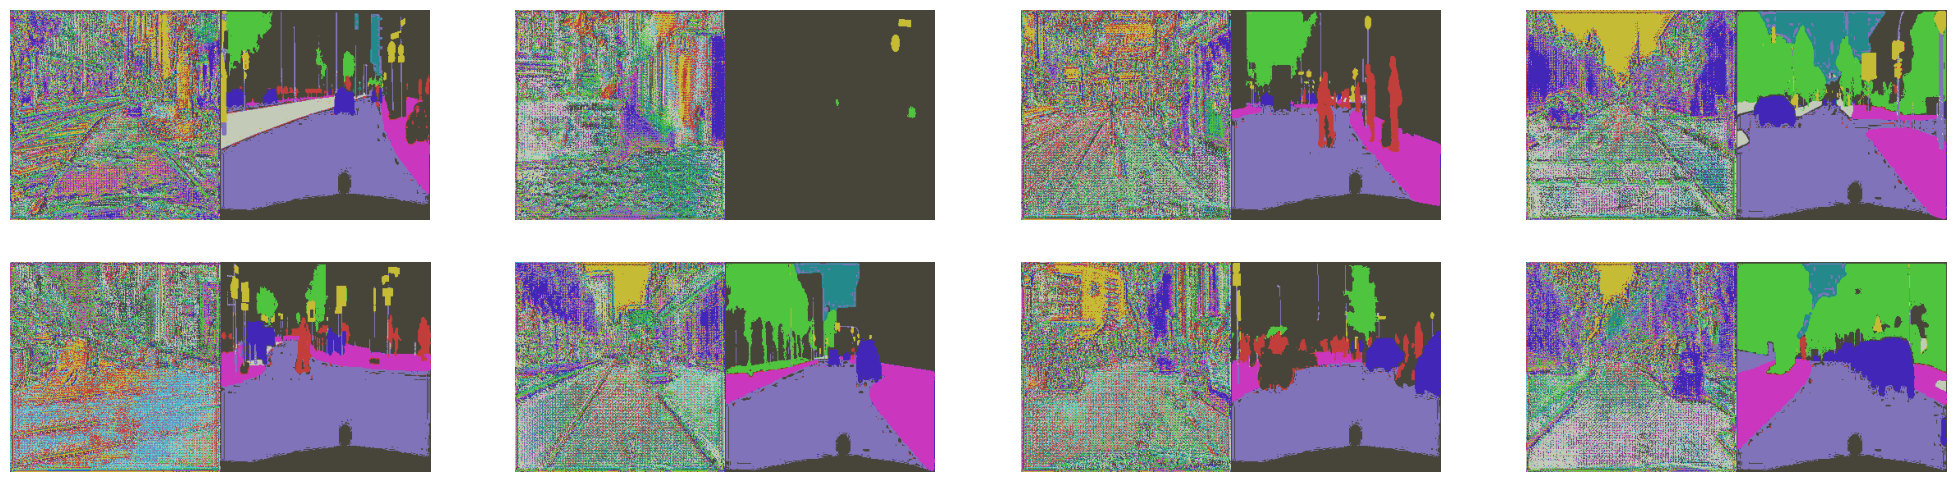

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch:0] Train:[loss:0.9120 iou:0.5952]Val:[loss:0.7462 iou:0.6531]


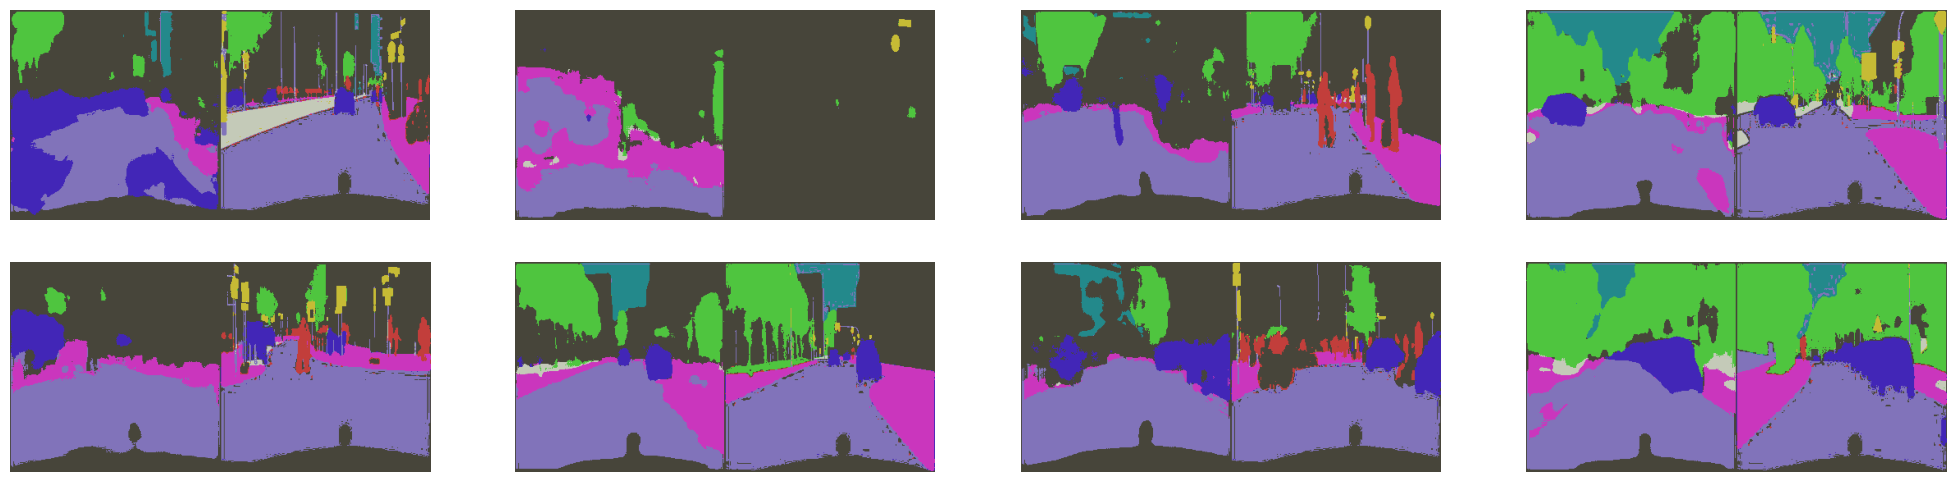

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch:1] Train:[loss:0.6532 iou:0.6760]Val:[loss:0.6156 iou:0.6864]


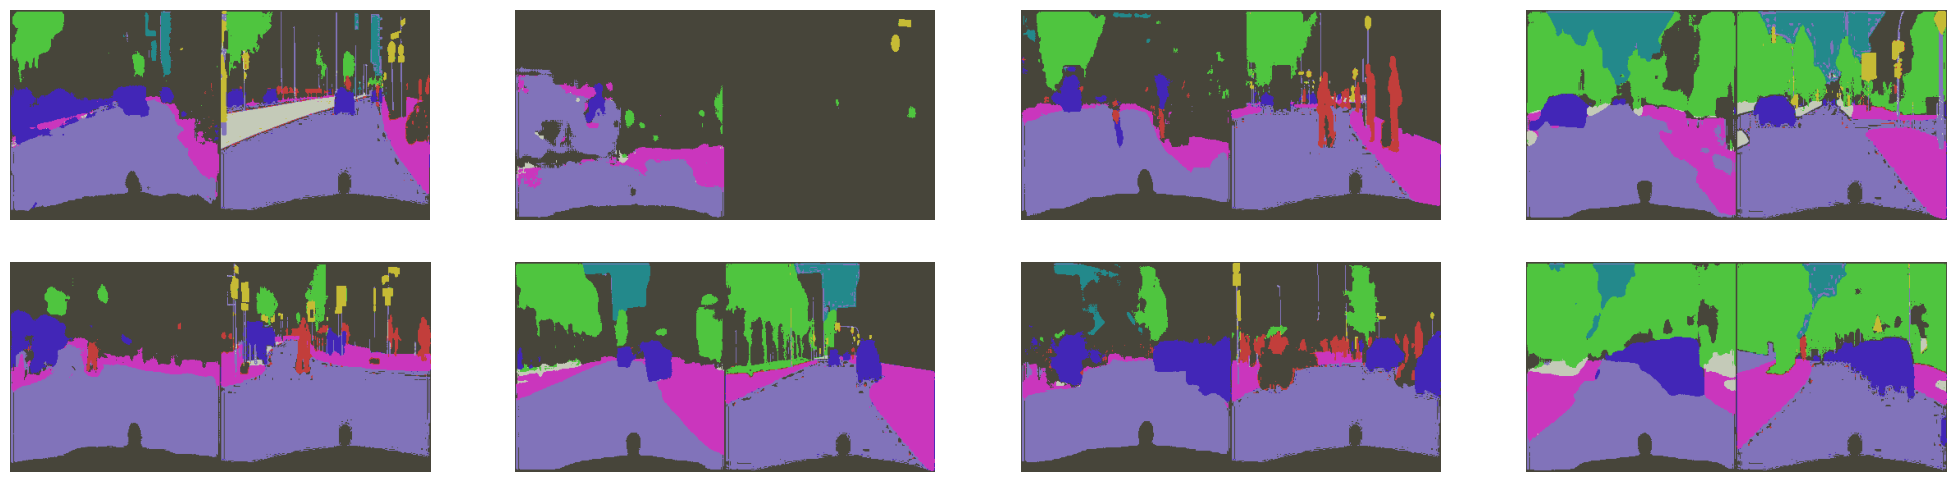

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch:2] Train:[loss:0.5637 iou:0.7089]Val:[loss:0.5563 iou:0.7065]


In [19]:
model_with_skips = UNet(num_classes = 10, skips=True)
get_num_parameters(model_with_skips)

trainer = Trainer(
    model=model_with_skips,
    train_loader=train_loader,
    val_loader=val_loader,
    colors=colors,
    device=device
)

trainer.train(epochs=3)


Number of parameters: 31,397,386


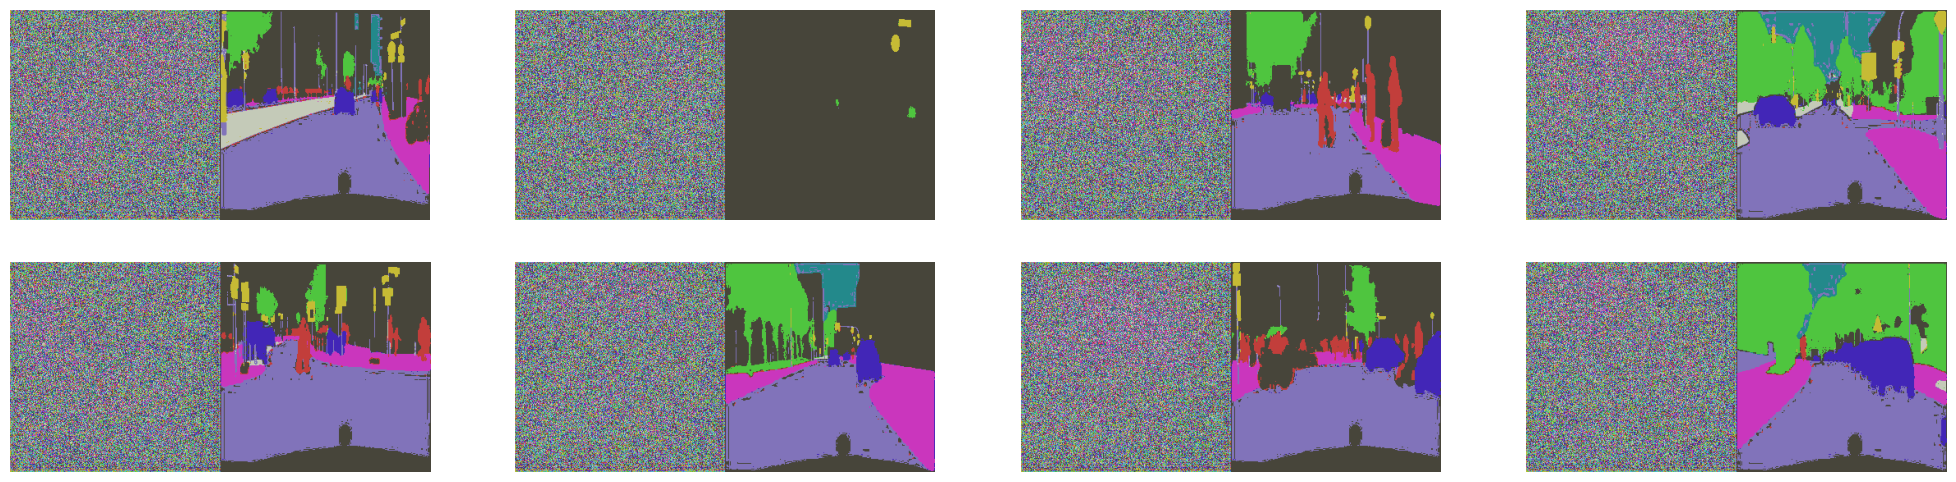

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch:0] Train:[loss:0.9458 iou:0.5779]Val:[loss:0.7418 iou:0.6403]


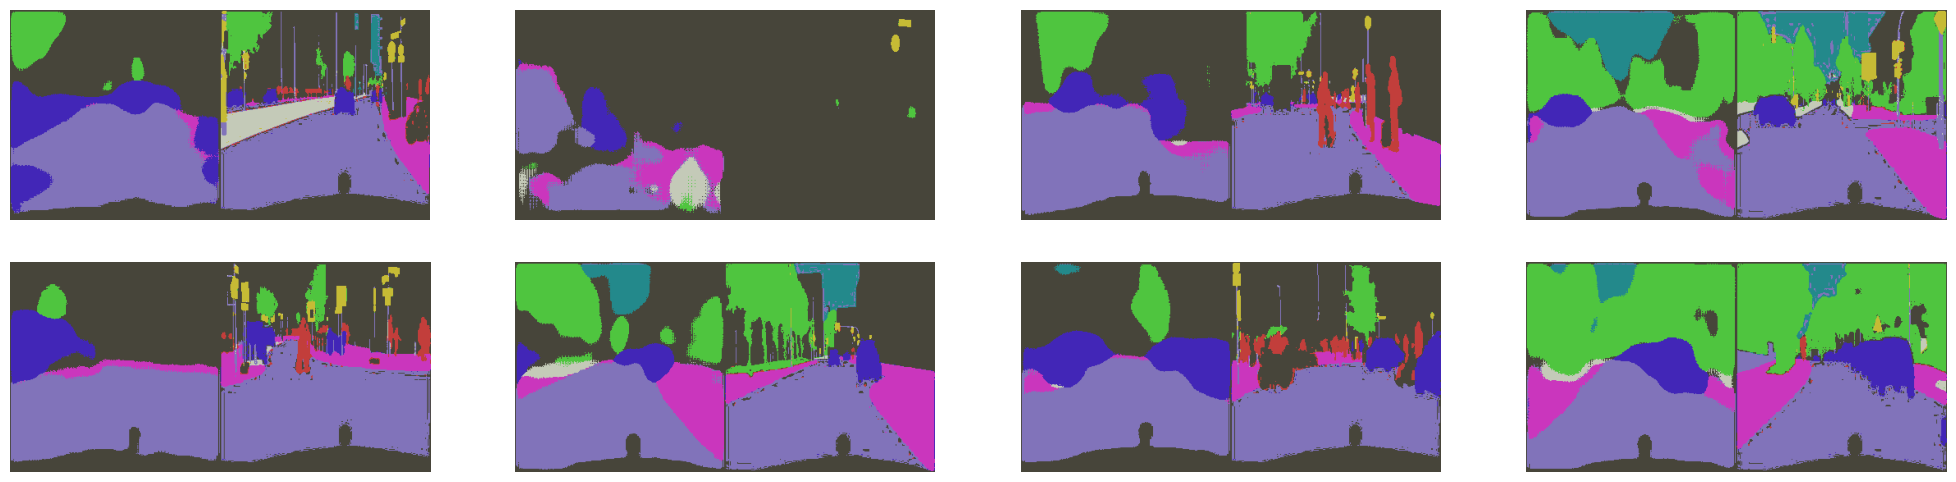

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch:1] Train:[loss:0.6734 iou:0.6690]Val:[loss:0.6331 iou:0.6777]


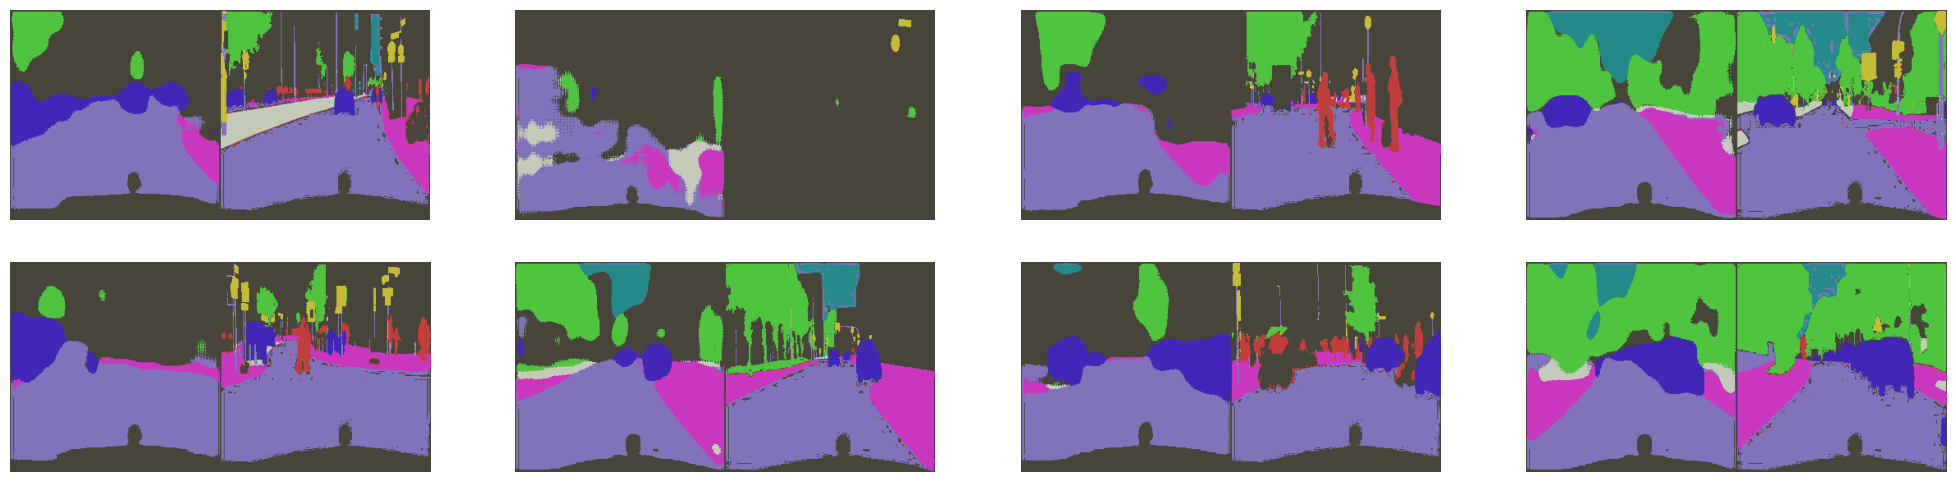

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch:2] Train:[loss:0.5870 iou:0.6998]Val:[loss:0.5878 iou:0.6971]


In [20]:
model_wo_skips = UNet(num_classes = 10, skips=False)
get_num_parameters(model_wo_skips)

trainer = Trainer(
    model=model_wo_skips,
    train_loader=train_loader,
    val_loader=val_loader,
    colors=colors,
    device=device
)

trainer.train(epochs=3)


In [22]:
torch.save(model_with_skips.state_dict(), './weights/model_with_skip.pth')
torch.save(model_wo_skips.state_dict(), './weights/model_wo_skip.pth')


#### Observations on IoU

<table>
    <tr>
        <th>Model</th>
        <th># Parameters</th>
        <th colspan="2">Epoch 1</th>
        <th colspan="2">Epoch 2</th>
        <th colspan="2">Epoch 3</th>
    </tr>
        <tr>
        <th></th>
        <th></th>
        <th colspan="1">Loss</th>
        <th colspan="1">IoU</th>
        <th colspan="1">Loss</th>
        <th colspan="1">IoU</th>
        <th colspan="1">Loss</th>
        <th colspan="1">IoU</th>
    </tr>
    <tr>
        <td>Unet with skips</td>
        <td>34.5M</td>
        <td>0.7462</td>
        <td>0.6531</td>
        <td>0.6156</td>
        <td>0.6864</td>
        <td>0.5563</td>
        <td>0.7065</td>
    </tr>
    </tr>
    </tr>
    <tr>
        <td>Unet w/o skips</td>
        <td>31.3M</td>
        <td>0.7418</td>
        <td>0.6403</td>
        <td>0.6331</td>
        <td>0.6777</td>
        <td>0.5878</td>
        <td>0.6971</td>
    </tr>
</table>

1. The IoU of UNet w/o skip connections is slightly less than that of UNet with skip connections.
2. One reason for similar performace of both the models is having a very small batch size. Because of a batch size of 8, the models go through a lot more gradient updates and hence optimizes equally well. 


### 3. Metric

The original implemented IoU directly uses ```logical_or```, ```logical_and``` on the model prediction which is infact incorrect because the model output probabilities for each class for each pixel. Hence, first we need to take the argmax over all the pixels and then for each label in ground truth extract the mask both in prediction and ground truth and find the IoU. Finally, the IoUs can be averaged for all the labels or a weighted average based on the frequence of each label, the later being implemented here. 



In [29]:
def report_iou(model, loader):
    ious = []
    for x, y in tqdm(loader):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            iou = trainer.calc_iou(y, torch.argmax(y_pred.detach(), dim=1))
            ious.append(iou.item())
    
    return ious

iou_with_skips = report_iou(model_with_skips, val_loader)
iou_wo_skips = report_iou(model_wo_skips, val_loader)


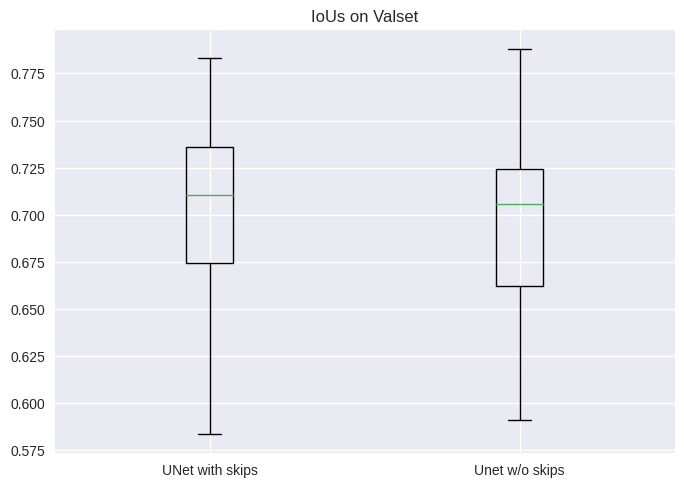

In [46]:
plt.boxplot([iou_with_skips, iou_wo_skips], positions=[1, 2])
plt.xticks([1, 2], ['UNet with skips', 'Unet w/o skips'])
plt.title('IoUs on Valset')
plt.show()

In [51]:
print(f"mIoU of UNet with skips: {np.mean(iou_with_skips):.5f}")
print(f"mIoU of UNet w/o skips: {np.mean(iou_wo_skips):.5f}")


mIoU of UNet with skips: 0.70649
mIoU of UNet w/o skips: 0.69707


## Q2: Contrastive Language-Image Pretraining

### 1. Setup Models

In [39]:
resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1).to(device).eval()
resnet_transform = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.transforms()

get_num_parameters(resnet50)

Number of parameters: 25,557,032


/home2/md.faizal/miniforge3/envs/cong/lib/python3.9/site-packages/torch/hub.py:700: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [20]:
import clip
# print(clip.available_models())
clip_resnet, preprocess = clip.load("RN50", device=device)
clip_resnet.eval()
clip_resnet.float()
# clip_resnet.half()

get_num_parameters(clip_resnet)

Number of parameters: 102,007,137


In [ ]:
for name, param in clip_resnet.visual.named_parameters():
    # param = param.to(torch.float32)
    print(name, param.dtype, param.shape)

### 2. Setup data

##### Imagenet Dataset

<img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg"></img>

The ImageNet dataset is a vast collection of labeled images, pivotal for advancing computer vision research. It contains millions of images across thousands of categories, supporting tasks like image classification and object detection. This dataset has helped progress in deep learning, particularly with convolutional neural networks. Pre-trained models on ImageNet, such as AlexNet, ResNet, VGG etc, serve as foundational tools for various applications. 


1. The label hierarchy used in ImageNet is based on WordNet, a large lexical database of English. ImageNet organizes its labels into a hierarchical structure that follows WordNet's synsets (sets of synonyms).

2.  A synset, short for "synonym set," is a group of words or terms that are synonymous or semantically related. In the context of ImageNet and WordNet, a synset represents a set of words or phrases that describe the same concept or object.

3. Yes, grouping images based on synsets can lead to problems because synsets group words based on semantical concepts whereas for tasks like visual recognition, we want grouping based on visual features. That is, these semantical similarities might be irrelevant for vision based models. Also, images in the same synset can still have different visual features.

4.  (i) Difference in color, size, shape. \
    (ii) Difference in the background setting of the object. Even though the object is present in the image, but the background can still vary which leads to contextual differences. \
    (iii) 

Dataset download: wget https://image-net.org/data/tiny-imagenet-200.zip

#### 3. Zero-shot CLIP

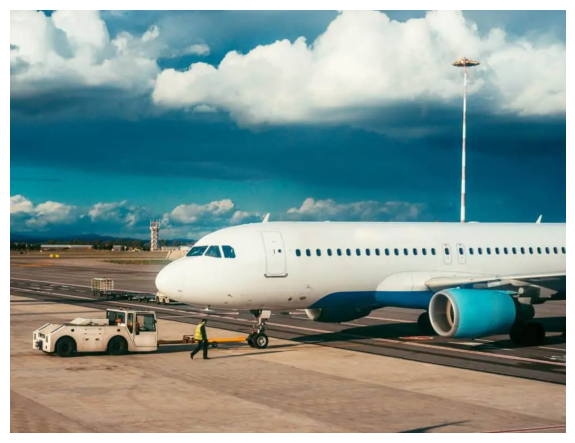

In [126]:
IMG_URL = 'https://www.connollycove.com/wp-content/uploads/2022/09/Air-Statistics-2-1024x781.jpg'

img = get_image(IMG_URL, img_size=None)
img = np.array(img)
plt.imshow(img)
plt.axis('off')
plt.show()

In [127]:
from PIL import Image

def get_clip_pred(img, text):
    img_clip = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
    text_clip = clip.tokenize(text).to(device)
    time_taken = time.time()
    
    with torch.no_grad():
        logits, _ = clip_resnet(img_clip, text_clip)
        probs = logits.softmax(dim=-1).cpu()
    time_taken = time.time() - time_taken
        
    return {
        'probs': probs.numpy(), 
        'label': text[torch.argmax(probs, dim=-1)[0]],
        'time_taken': time_taken
    }

In [131]:
get_clip_pred(img, ["car", "road", "car pushback"])

{'probs': array([[0.044  , 0.02248, 0.9336 ]], dtype=float16),
 'label': 'car pushback',
 'time_taken': 0.031629085540771484}

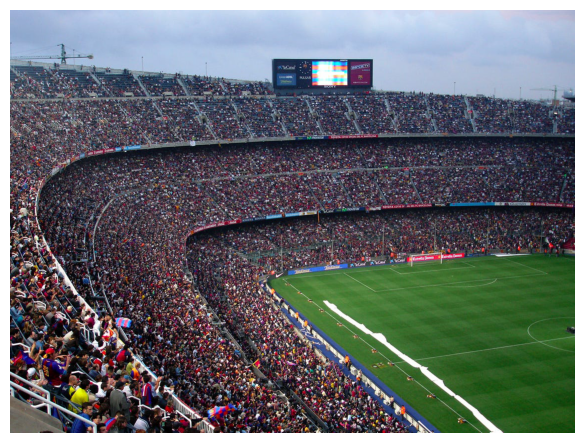

{'probs': array([[8.032e-02, 1.469e-04, 9.194e-01, 1.423e-04]], dtype=float16),
 'label': 'football stadium',
 'time_taken': 0.026594877243041992}

In [113]:
IMG_URL = 'https://i.insider.com/572d8464dd08956c3e8b4574?width=1136&format=jpeg'

img = get_image(IMG_URL, img_size=None)
img = np.array(img)
plt.imshow(img)
plt.axis('off')
plt.show()

get_clip_pred(img, ["a huge crowd", "buildings", "football stadium", "grass"])

In [120]:
img_resnet = resnet_transform(torch.from_numpy(img).permute(2, 0, 1)).to(device)

with torch.no_grad():
    pred = resnet50(img_resnet.unsqueeze(0))
    pred = torch.nn.functional.softmax(pred, dim=-1)
    pred_label = torch.argmax(pred, dim=-1).item()
    
print(imagenet[pred_label], ":", torch.max(pred), pred_label)

airliner : tensor(0.9462, device='cuda:0') 404


In [143]:
np.mean(time_list), np.std(time_list)

(0.01726883411407471, 0.00659640681972343)

#### 5. Converting CLIP image encoder to FP16


In [24]:
def clip_image_encoder_inference(PATH, fp='half'):
    files = [os.path.join(PATH, f) for f in os.listdir(PATH)]

    time_list = []

    for img in tqdm(files):
        img = plt.imread(img)
        img = cv2.resize(img, (224, 224))
        img_clip = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        if fp == 'half':
            img_clip.half()
        else:
            img_clip.float()
            
        time_taken = time.time()
        with torch.no_grad():
            clip_resnet.encode_image(img_clip)
            
        time_taken = time.time() - time_taken 
        time_list.append(time_taken)
        
    print(f"Time taken: {np.mean(time_list):.5f} ({np.std(time_list)})")
    

PATH = '/scratch/fk/tiny-imagenet-200/train/n01443537/images'

print("With FP32")    
clip_image_encoder_inference(PATH, fp='double')
print("=" * 100)

clip_resnet.half()
print("With FP16")    
clip_image_encoder_inference(PATH, fp='half')


With FP32


  0%|          | 0/500 [00:00<?, ?it/s]

Time taken: 0.01421 (0.002399904570614953)
With FP16


  0%|          | 0/500 [00:00<?, ?it/s]

Time taken: 0.01432 (0.002343377003097235)
